In [68]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
from prophet import Prophet

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv('Electric_Consumption_And_Cost__2010_-_April_2020_.csv')
df = df[['Service End Date', 'Consumption (KW)', 'Borough']].copy().dropna()
df.head()

# df.dtypes

,Service End Date,Consumption (KW),Borough
0,01/26/2010,216.0,BRONX
1,02/25/2010,224.0,BRONX
2,03/26/2010,216.0,BRONX
3,04/26/2010,208.0,BRONX
4,05/24/2010,216.0,BRONX


## Preparing data for training

In [3]:
# Determining time series
df['Service End Date'] = pd.to_datetime(df['Service End Date'], dayfirst=True)
# df.columns = ['y', 'ds']

df['month'], df['year'] = df['Service End Date'].dt.month, df['Service End Date'].dt.year
df.head()

daily_df = df[['Service End Date', 'Consumption (KW)']].copy().dropna()
daily_df.columns = ['ds', 'y']
daily_df.head()

daily_df.dtypes

monthly_df = daily_df.groupby(pd.PeriodIndex(daily_df['ds'], freq='M'))['y'].mean().to_timestamp().reset_index()
monthly_df.head()
monthly_df.dtypes

annual_df = daily_df.groupby(pd.PeriodIndex(daily_df['ds'], freq='Y'))['y'].mean().to_timestamp().reset_index()
annual_df.head()
# annual_df.dtypes


,ds,y
0,2010-01-01,86.332974
1,2011-01-01,0.000000
2,2012-01-01,71.050691
3,2013-01-01,66.071398
4,2014-01-01,62.291844


### Training the Models and evaluating forecasts

In [44]:
def train_model(growth, seasonality, df):
    model = None

    if seasonality == 'daily':
        model = Prophet(interval_width=0.95, growth=growth, changepoint_prior_scale=30, n_changepoints=3,
        daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
        model.add_seasonality('daily', period=1, fourier_order=15)
        model.fit(df)

    elif seasonality == 'monthly':
        model = Prophet(interval_width=0.95, growth=growth, changepoint_prior_scale=30, n_changepoints=3,
        daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
        model.add_seasonality(name='monthly', period=30.5, fourier_order=12)
        model.fit(df)

    elif seasonality == 'annual':
        model = Prophet(interval_width=0.95, growth=growth, changepoint_prior_scale=30, n_changepoints=2,
         daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
        model.add_seasonality(name='annual', period=365.25, fourier_order=20)
        model.fit(df)      

    return model


### Forecasting 

In [59]:
def get_forecast(model, time_period, freq):
    future_df = model.make_future_dataframe(periods=time_period, freq=freq)
    forecast = model.predict(future_df)
    return future_df, forecast

def evaluate_forecast(forecast, actual, time_period):
    # y_true = cv_results.y
    # y_pred = cv_results.yhat
    # print(len(forecast))
    y_true = actual
    y_pred = forecast[:(len(forecast)-time_period)]

    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("Mean Absolute Error :", mae)
    print("Mean Absolute Percentage Error :", mape)
    plt.plot(forecast, c='orange', label='Predicted')
    plt.plot(y_true, c='blue', label='Actual')
    plt.legend(loc='lower right')
    plt.show()

def evaluate_forecast_daily(forecast, actual):
    # y_true = cv_results.y
    # y_pred = cv_results.yhat
    print(len(forecast))
    y_true = actual[-len(forecast):]
    y_pred = forecast

    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print("Mean Absolute Error :", mae)
    print("Mean Absolute Percentage Error :", mape)
    plt.plot(y_pred, c='orange', label='Predicted')
    plt.plot(y_true, c='blue', label='Actual')
    plt.legend(loc='lower right')
    plt.axis([0, 400, 0, 500])
    plt.show()


##### Daily consumption forecast

In [45]:

df_daily = pd.DataFrame(daily_df[-6000:])
df_daily.dtypes
model_daily = train_model(growth='linear', seasonality='daily', df=df_daily)
future_daily, forecast_daily = get_forecast(model=model_daily, time_period=365, freq='D')

forecast_daily.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-24,179.527872,-102.281125,185.612981,179.527872,179.527872,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,0.0,0.0,0.0,39.727765
1,2020-02-25,178.884936,-99.336698,174.084493,178.884936,178.884936,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,0.0,0.0,0.0,39.084829
2,2020-03-25,178.302276,-105.247077,176.713390,178.302276,178.302276,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,0.0,0.0,0.0,38.502169
3,2020-04-08,178.020992,-97.560578,184.432235,178.020992,178.020992,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,0.0,0.0,0.0,38.220885
4,2020-04-23,177.719616,-102.326792,189.205636,177.719616,177.719616,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,-139.800107,0.0,0.0,0.0,37.919509


384
Mean Absolute Error : 51.7152529121042
Mean Absolute Percentage Error : 1.0247472295734669e+17


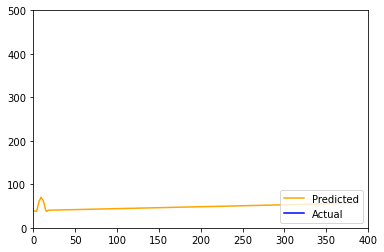

In [60]:
evaluate_forecast_daily(forecast_daily['yhat'], df_daily['y'])

#### Monthly Forecast

In [62]:
model_monthly = train_model(growth='linear', seasonality='monthly', df=monthly_df)
future_monthly, forecast_monthly = get_forecast(model=model_monthly, time_period=1, freq='M')

forecast_monthly.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,30.753371,36.272486,113.782043,30.753371,30.753371,45.921159,45.921159,45.921159,45.921159,45.921159,45.921159,0.0,0.0,0.0,76.674530
1,2010-02-01,30.258784,31.738187,109.928929,30.258784,30.258784,39.609892,39.609892,39.609892,39.609892,39.609892,39.609892,0.0,0.0,0.0,69.868676
2,2010-03-01,29.812060,40.842208,119.952226,29.812060,29.812060,51.184888,51.184888,51.184888,51.184888,51.184888,51.184888,0.0,0.0,0.0,80.996948
3,2010-04-01,29.317473,49.341050,128.463723,29.317473,29.317473,57.838222,57.838222,57.838222,57.838222,57.838222,57.838222,0.0,0.0,0.0,87.155695
4,2010-05-01,28.838841,41.577976,118.872733,28.838841,28.838841,51.184888,51.184888,51.184888,51.184888,51.184888,51.184888,0.0,0.0,0.0,80.023729


Mean Absolute Error : 14.593147219860176
Mean Absolute Percentage Error : 2718267092152921.5


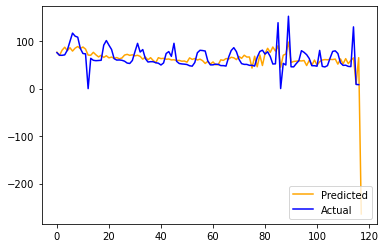

In [63]:
evaluate_forecast(forecast_monthly['yhat'], monthly_df['y'], 1)

#### Annual Forecast

In [65]:
model_annual= train_model(growth='linear', seasonality='annual', df=annual_df)
future_annual, forecast_annual = get_forecast(model=model_annual, time_period=1, freq='Y')

forecast_annual.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,annual,annual_lower,annual_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,7.955614,16.957103,96.612775,7.955614,7.955614,48.313398,48.313398,48.313398,48.313398,48.313398,48.313398,0.0,0.0,0.0,56.269012
1,2011-01-01,8.210742,13.382518,92.961090,8.210742,8.210742,45.575222,45.575222,45.575222,45.575222,45.575222,45.575222,0.0,0.0,0.0,53.785964
2,2012-01-01,8.465870,14.580898,89.612499,8.465870,8.465870,43.902086,43.902086,43.902086,43.902086,43.902086,43.902086,0.0,0.0,0.0,52.367956
3,2013-01-01,8.721697,21.672821,96.533668,8.721697,8.721697,52.095222,52.095222,52.095222,52.095222,52.095222,52.095222,0.0,0.0,0.0,60.816919
4,2014-01-01,8.976824,18.803558,96.939426,8.976824,8.976824,48.313398,48.313398,48.313398,48.313398,48.313398,48.313398,0.0,0.0,0.0,57.290222


Mean Absolute Error : 13.09877731927917
Mean Absolute Percentage Error : 2.0185870746266464e+16


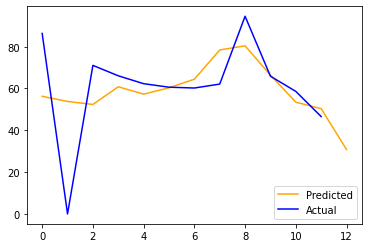

In [67]:
evaluate_forecast(forecast_annual['yhat'], annual_df['y'], 1)